In [1]:
import os
import shutil
import glob
from tqdm import tqdm  

BASE_PATH = r"C:\Users\ADMIN\Documents\Dev_Projects\Traffic_Infosys\UVH-26_dataset"
TRAIN_IMG_DIR = os.path.join(BASE_PATH, "UVH-26-Train", "data")
TRAIN_LBL_DIR = os.path.join(BASE_PATH, "UVH-26-Train", "yolo_labels")

MIN_TARGET = 8000

# Classes to Boost (Rare classes only)
# ID 3: MUV
# ID 10: Tempo-traveller
# ID 11: Bicycle
# ID 12: Van
BOOST_IDS = [3, 10, 11, 12]

print(f"Configuration Loaded. Targeting {MIN_TARGET} instances for classes {BOOST_IDS}.")

Configuration Loaded. Targeting 8000 instances for classes [3, 10, 11, 12].


In [2]:
def get_files_with_class(class_id, label_dir):
    matches = []
    
    all_txts = glob.glob(os.path.join(label_dir, "**", "*.txt"), recursive=True)
    
    for path in all_txts:
        if os.path.getsize(path) == 0: continue
        try:
            with open(path, 'r') as f:
                for line in f:
                    if int(line.split()[0]) == class_id:
                        rel_dir = os.path.relpath(os.path.dirname(path), label_dir)
                        matches.append((path, rel_dir))
                        break 
        except:
            continue
    return matches

In [3]:
print(f"--- Starting Redistribution (Target: {MIN_TARGET} instances) ---")

total_copies_generated = 0

for cls_id in BOOST_IDS:
    print(f"\n--- Checking Class ID {cls_id} ---")
    
    # 1. Find existing examples
    valid_files = get_files_with_class(cls_id, TRAIN_LBL_DIR)
    current_count = len(valid_files)
    
    # 2. Check if we need to boost
    if current_count >= MIN_TARGET:
        print(f" -> Count {current_count} is already good. Skipping.")
        continue
        
    needed = MIN_TARGET - current_count
    print(f" -> Found {current_count}. Generating {needed} copies...")
    
    # 3. Generate Copies
    pbar = tqdm(total=needed, desc=f"Boosting Class {cls_id}")
    copies_made = 0
    idx = 0
    
    while copies_made < needed:
        src_lbl_path, rel_dir = valid_files[idx % len(valid_files)]
        idx += 1
        
        base_name = os.path.splitext(os.path.basename(src_lbl_path))[0]
        src_img_dir = os.path.join(TRAIN_IMG_DIR, rel_dir)
        
        ext = None
        for e in ['.jpg', '.jpeg', '.png']:
            if os.path.exists(os.path.join(src_img_dir, base_name + e)):
                ext = e
                break
        
        if not ext: continue 
        
        new_name = f"{base_name}_aug_{copies_made}"
        dst_lbl_path = os.path.join(TRAIN_LBL_DIR, rel_dir, new_name + ".txt")
        dst_img_path = os.path.join(TRAIN_IMG_DIR, rel_dir, new_name + ext)
        
        shutil.copy(os.path.join(src_img_dir, base_name + ext), dst_img_path)
        shutil.copy(src_lbl_path, dst_lbl_path)
        
        copies_made += 1
        total_copies_generated += 1
        pbar.update(1)
        
    pbar.close()

print(f"\n\nSUCCESS: Dataset redistributed. Total new images created: {total_copies_generated}")

--- Starting Redistribution (Target: 8000 instances) ---

--- Checking Class ID 3 ---
 -> Found 4412. Generating 3588 copies...


Boosting Class 3: 100%|████████████████████████████████████████████████████████████| 3588/3588 [00:43<00:00, 82.32it/s]



--- Checking Class ID 10 ---
 -> Found 1459. Generating 6541 copies...


Boosting Class 10: 100%|██████████████████████████████████████████████████████████| 6541/6541 [00:41<00:00, 159.53it/s]



--- Checking Class ID 11 ---
 -> Found 3005. Generating 4995 copies...


Boosting Class 11: 100%|██████████████████████████████████████████████████████████| 4995/4995 [00:43<00:00, 113.88it/s]



--- Checking Class ID 12 ---
 -> Found 2494. Generating 5506 copies...


Boosting Class 12: 100%|██████████████████████████████████████████████████████████| 5506/5506 [00:39<00:00, 137.90it/s]



SUCCESS: Dataset redistributed. Total new images created: 20630


Re-scanning Train files 
Re-scanning Validation files 


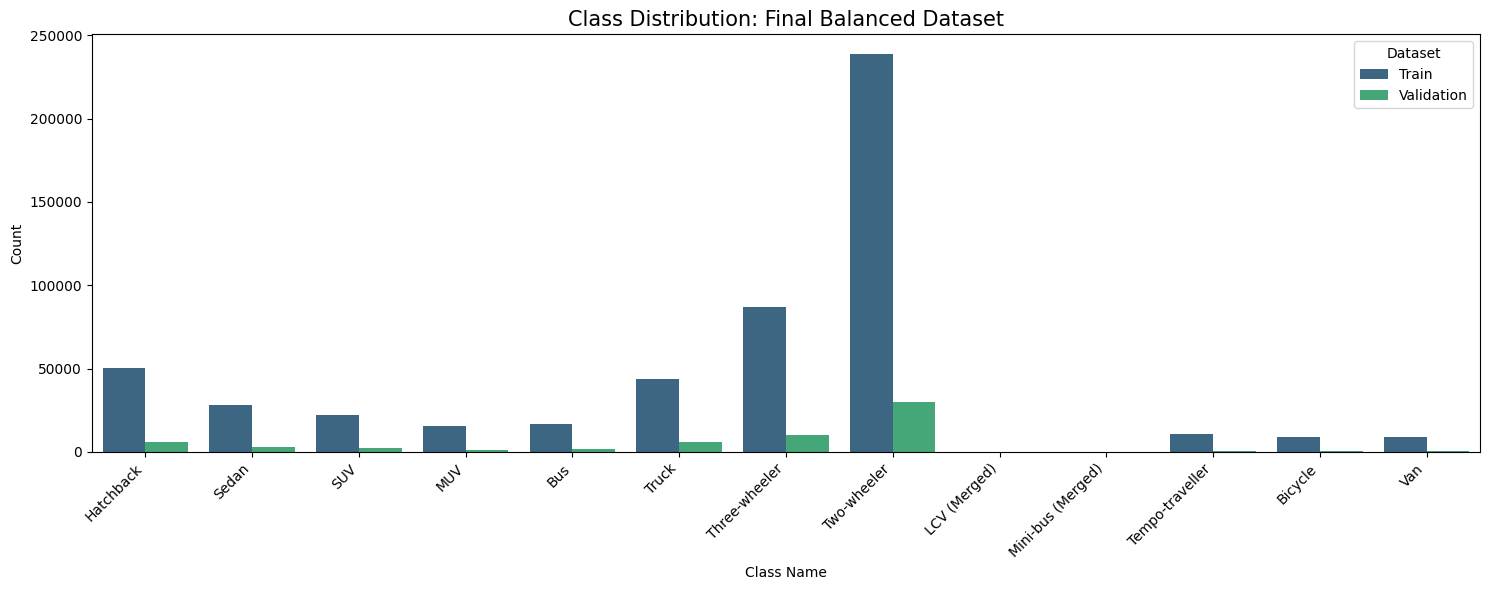


--- Final Counts Table ---


class_name,Bicycle,Bus,Hatchback,MUV,SUV,Sedan,Tempo-traveller,Three-wheeler,Truck,Two-wheeler,Van
subset,,,,,,,,,,,
Train,9285,16909,50588,15676,22420,28303,10718,86873,43994,238586,8950
Validation,681,2004,6094,1315,2639,3151,335,10467,6087,30211,443


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob

# --- CONFIGURATION (Re-confirming paths) ---
TRAIN_LBL_DIR = os.path.join(BASE_PATH, "UVH-26-Train", "yolo_labels")
VAL_LBL_DIR = os.path.join(BASE_PATH, "UVH-26-Val", "yolo_labels")

# The Class List must match your 'Merged' logic
CLASSES = [
    'Hatchback', 'Sedan', 'SUV', 'MUV', 'Bus', 'Truck', 
    'Three-wheeler', 'Two-wheeler', 'LCV (Merged)', 'Mini-bus (Merged)', 
    'Tempo-traveller', 'Bicycle', 'Van'
]

def load_simple_counts(root_dir, subset_name):
    """Scans files to count class occurrences."""
    data = []
    print(f"Re-scanning {subset_name} files ")
    
    txt_files = glob.glob(os.path.join(root_dir, "**", "*.txt"), recursive=True)
    
    for file_path in txt_files:
        if os.path.getsize(file_path) == 0: continue
        
        # We only need to read the first character of each line for counting
        with open(file_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 1:
                    try:
                        cls_id = int(parts[0])
                        if 0 <= cls_id < len(CLASSES):
                            data.append(CLASSES[cls_id])
                    except ValueError:
                        continue
    
    return pd.DataFrame(data, columns=["class_name"]).assign(subset=subset_name)

# 1. Load the freshly updated data
df_train = load_simple_counts(TRAIN_LBL_DIR, "Train")
df_val = load_simple_counts(VAL_LBL_DIR, "Validation") # Load val just for comparison
df = pd.concat([df_train, df_val], ignore_index=True)

# 2. Plot
plt.figure(figsize=(15, 6))
# We define the order explicitly to keep the chart clean
sns.countplot(data=df, x='class_name', hue='subset', order=CLASSES, palette='viridis')

plt.title("Class Distribution: Final Balanced Dataset", fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Class Name")
plt.ylabel("Count")
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()

# 3. Print Exact Counts
print("\n--- Final Counts Table ---")
# This will show you exactly how many 'Bicycle' or 'Van' labels you have now
count_table = df.groupby(['subset', 'class_name']).size().unstack(fill_value=0)
display(count_table)